## 一般化線形モデル　ポアソン回帰のモデリング事例

In [29]:
# ライブラリ
import os
import sys
sys.path.append("../../scripts")
import warnings
warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
np.random.seed(111)
import random
random.seed(111)

# pingouin
from sklearn.metrics import r2_score
# statsmodels
import statsmodels.api as sm
# graph
import matplotlib.pyplot as plt
import seaborn as sns

# scripts
import utils as u
# graph setting
u.graph_setting()

以下のscikit-learnのデータセットを用いる。<br>
ある学校の3つの種目の運動を行った際の、20人の学生の体重や脈拍数などの情報が含まれるデータセット

In [22]:
from sklearn.datasets import load_linnerud

# データセットの読み込み
linnerud_data = load_linnerud()

# 特徴量とターゲットの取得
X = linnerud_data.data
y = linnerud_data.target[:, 0]  # 体重の列をターゲットとする

# データフレーム化
df = pd.DataFrame(X, columns=linnerud_data.feature_names)
df[linnerud_data.target_names] = linnerud_data.target


print("Dataset size : ", df.shape)
df.head()

Dataset size :  (20, 6)


,Chins,Situps,Jumps,Weight,Waist,Pulse
0,5.0,162.0,60.0,191.0,36.0,50.0
1,2.0,110.0,60.0,189.0,37.0,52.0
2,12.0,101.0,101.0,193.0,38.0,58.0
3,12.0,105.0,37.0,162.0,35.0,62.0
4,13.0,155.0,58.0,189.0,35.0,46.0


# データ確認

### 各変数
Chins: チンニング（懸垂運動）の反復回数<br>
Situps: 背筋の反復回数<br>
Jumps: 跳躍運動の反復回数<br>
Weight: 体重<br>
Waist: 腰回りのサイズ<br>
Pulse: 心拍数<br>

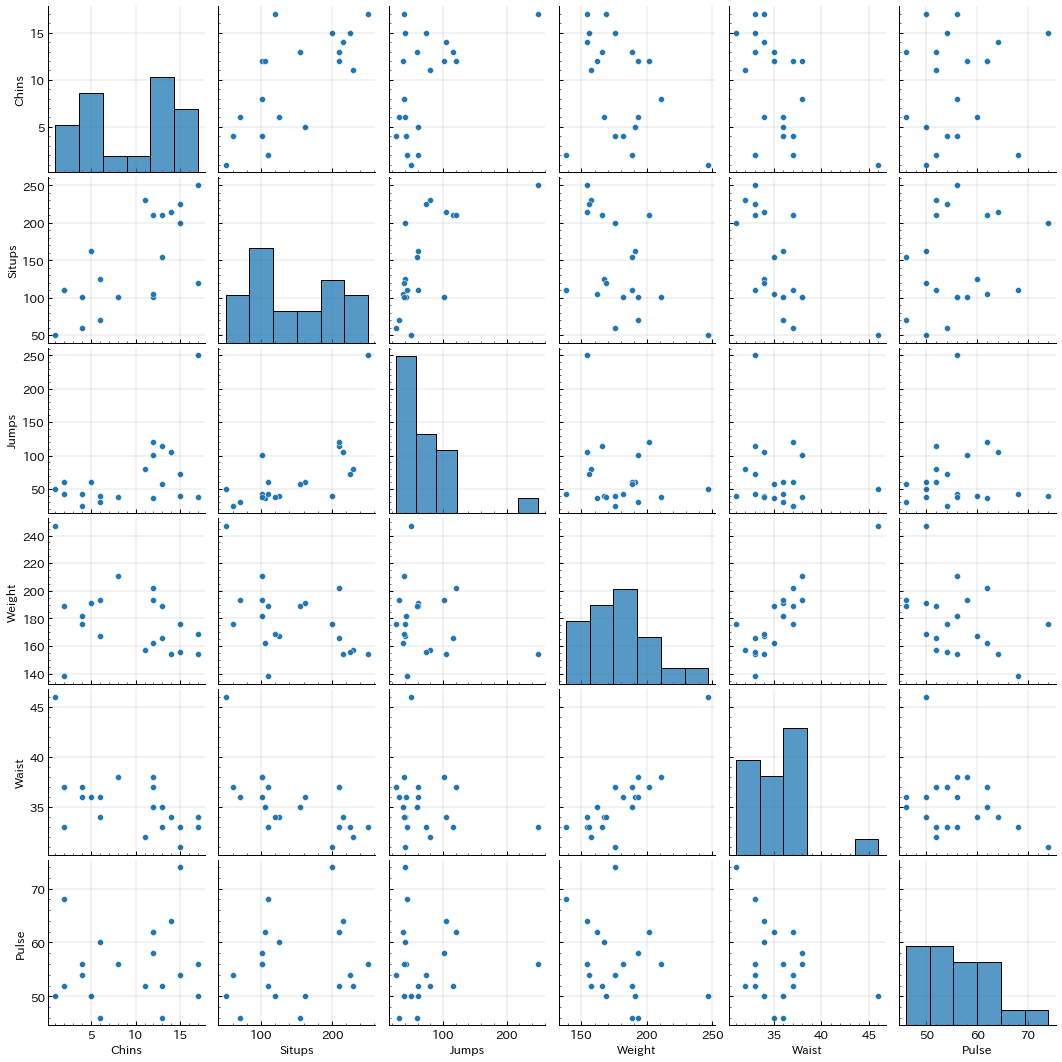

In [23]:
# データの分布確認
sns.pairplot(df)

# モデリングの問題設定

目的変数 : Jumps<br>
説明変数 : その他の変数<br>

# モデルの仮定

### Jumpsのデータの特徴
- 0以上
- 自然数
### よってポアソン回帰でモデリングを行う。

- ポアソン回帰モデル<br>
  応答変数が非負の整数の場合に使用する。リンク関数には対数関数を使用し、分布族はポアソン分布を仮定する<br>
  
  モデル式<br>
  $\ln(\mu) = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_p x_p$
  
  解法<br>
  最尤推定法<br>
  
  尤度関数<br>
  $L(\beta) = \prod_{i=1}^{n}\frac{\mu_i^{y_i}e^{-\mu_i}}{y_i!}$

In [46]:
# ポアソン回帰モデルの構築
model = sm.Poisson.from_formula('Jumps ~ Chins + Situps + Weight + Waist + Pulse', data=df)
result = model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 5.987100
         Iterations 6
                          Poisson Regression Results                          
Dep. Variable:                  Jumps   No. Observations:                   20
Model:                        Poisson   Df Residuals:                       14
Method:                           MLE   Df Model:                            5
Date:                Sat, 06 May 2023   Pseudo R-squ.:                  0.6395
Time:                        19:30:08   Log-Likelihood:                -119.74
converged:                       True   LL-Null:                       -332.13
Covariance Type:            nonrobust   LLR p-value:                 1.355e-89
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.0420      0.613     -3.330      0.001      -3.244      -0.840
Chins          0.0286      0.

### モデルの解釈
Chins : 上昇するとJumpsも上昇する。<br>
Situps : 上昇するとJumpsも上昇する。しかしChinsよりもその効果は小さい。<br>
Weight : 体重が重いとJumpsは減少する。<br>
Waist : ウエストが大きいとJumpsは減少する。この項が最も大きい。<br>
Pulse : 心拍数が高いとJumpsは減少する。しかし。その影響は小さい。<br>

### 考察
Waistの項は、あり得なくもないが通常ウエストが大きいと体重が重くJumpsの回数が増えるとは考えにくい。<br>
データを見ると、WeightとWaistは相関が高く共線性を持っていることが分かる。これを両方入れる事は、モデリングにおいて良くない。<br>
➡Waistの情報を除いた状態で、再度モデリングする。

In [55]:
# ポアソン回帰モデルの構築
model = sm.Poisson.from_formula('Jumps ~ Chins + Situps + Weight + Pulse', data=df)
result_2 = model.fit()
print(result_2.summary())

Optimization terminated successfully.
         Current function value: 8.242344
         Iterations 6
                          Poisson Regression Results                          
Dep. Variable:                  Jumps   No. Observations:                   20
Model:                        Poisson   Df Residuals:                       15
Method:                           MLE   Df Model:                            4
Date:                Sat, 06 May 2023   Pseudo R-squ.:                  0.5037
Time:                        19:34:27   Log-Likelihood:                -164.85
converged:                       True   LL-Null:                       -332.13
Covariance Type:            nonrobust   LLR p-value:                 3.773e-71
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.4665      0.400      6.170      0.000       1.683       3.250
Chins          0.0161      0.

In [60]:
result

# 予測結果の確認

真値と予測値のプロット

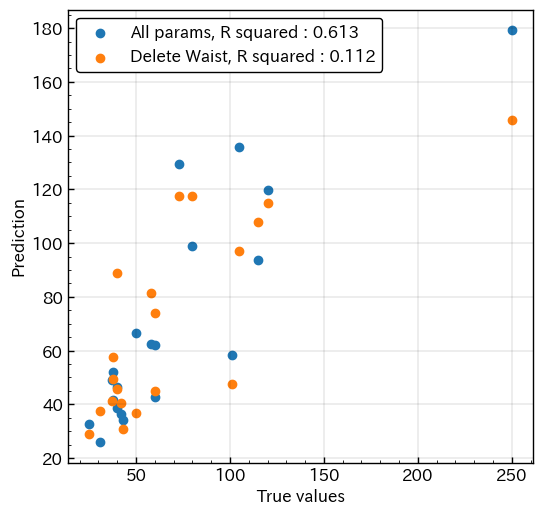

In [53]:
# Prediction
pred1 = result.predict(df)
pred2 = result_2.predict(df)

# plot
plt.figure(figsize=(6,6))
plt.scatter(df["Jumps"], pred1, label="All params, R squared : {}".format(round(r2_score(pred1, df["Jumps"]), 3)))
plt.scatter(df["Jumps"], pred2, label="Delete Waist, R squared : {}".format(round(r2_score(pred2, df["Jumps"]), 3)))
plt.xlabel("True values")
plt.ylabel("Prediction")
plt.legend()

ChinsとJumpsの予測プロット & 分布平均のプロット

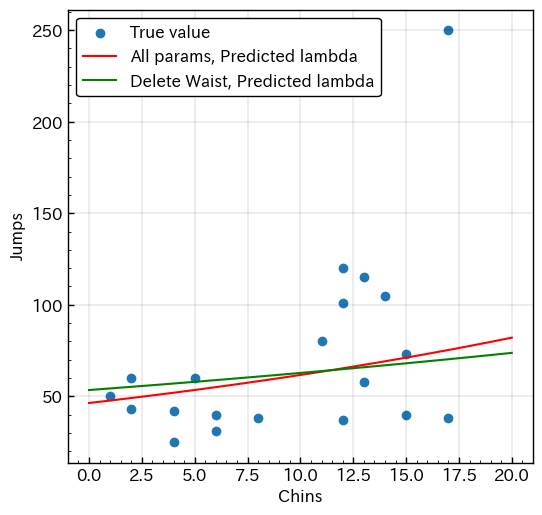

In [54]:
# 平均データを作る
cols = df.columns
# sampling parameter
ave_df = pd.DataFrame({"Chins":np.linspace(0,20,20)})
for c in cols:
    if c!="Chins":
        ave_df[c] = df[c].mean()

plt.figure(figsize=(6,6))
plt.scatter(df["Chins"], df["Jumps"], label="True value")
plt.plot(ave_df["Chins"], result.predict(ave_df), label="All params, Predicted lambda", color="red")
plt.plot(ave_df["Chins"], result_2.predict(ave_df), label="Delete Waist, Predicted lambda", color="green")
plt.xlabel("Chins")
plt.ylabel("Jumps")
plt.legend()

ChinsとJumpsの予測プロット & 分布平均の上側と下側をプロット<br>
プロットのベースは、Waistのパラメータを外したモデル

In [61]:
from scipy.stats import poisson

def return_poissonupr_lwr(lambda_:float, lower:float, upper:float):

    # define poisson
    mu = lambda_
    dist = poisson(mu)

    return dist.ppf(lower), dist.ppf(upper)

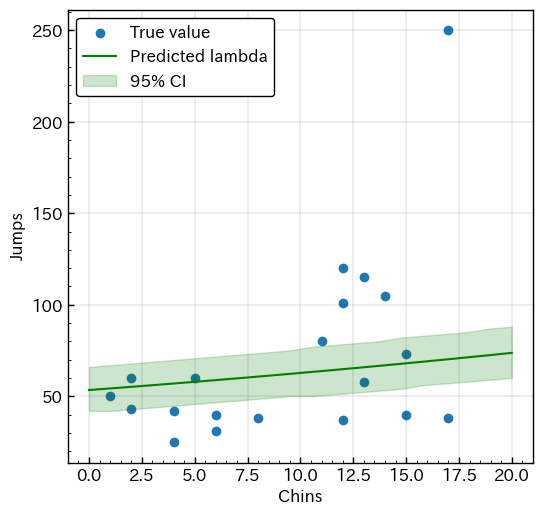

In [67]:
# 平均データを作る
cols = df.columns
# sampling parameter
ave_df = pd.DataFrame({"Chins":np.linspace(0,20,20)})
for c in cols:
    if c!="Chins":
        ave_df[c] = df[c].mean()

# confidence range
lower = []
upper = []
for c in result_2.predict(ave_df):
    l, u = return_poissonupr_lwr(c, 0.05, 0.95)
    lower.append(l)
    upper.append(u)

plt.figure(figsize=(6,6))
plt.scatter(df["Chins"], df["Jumps"], label="True value")
plt.plot(ave_df["Chins"], result_2.predict(ave_df), label="Predicted lambda", color="green")
plt.fill_between(ave_df["Chins"], lower, upper, label="95% CI", color="green", alpha=0.2)
plt.xlabel("Chins")
plt.ylabel("Jumps")
plt.legend()

モデリングできた範囲としては、あまりフィッティングが良くない。<br>
対応として、Jumpsを10範囲で区切るようなことを行い、各レンジにあたる確率分布を仮定する事とする。

In [76]:
# 目的変数を10で区切る
df_2 = df.copy()
df_2["Jumps"] = df_2["Jumps"]//5

# ポアソン回帰モデルの構築
model = sm.Poisson.from_formula('Jumps ~ Chins + Situps + Weight + Pulse', data=df_2)
result_3 = model.fit()
print(result_3.summary())

Optimization terminated successfully.
         Current function value: 3.240221
         Iterations 6
                          Poisson Regression Results                          
Dep. Variable:                  Jumps   No. Observations:                   20
Model:                        Poisson   Df Residuals:                       15
Method:                           MLE   Df Model:                            4
Date:                Sat, 06 May 2023   Pseudo R-squ.:                  0.3477
Time:                        19:57:15   Log-Likelihood:                -64.804
converged:                       True   LL-Null:                       -99.355
Covariance Type:            nonrobust   LLR p-value:                 3.514e-14
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7182      0.899      0.799      0.424      -1.044       2.480
Chins          0.0143      0.

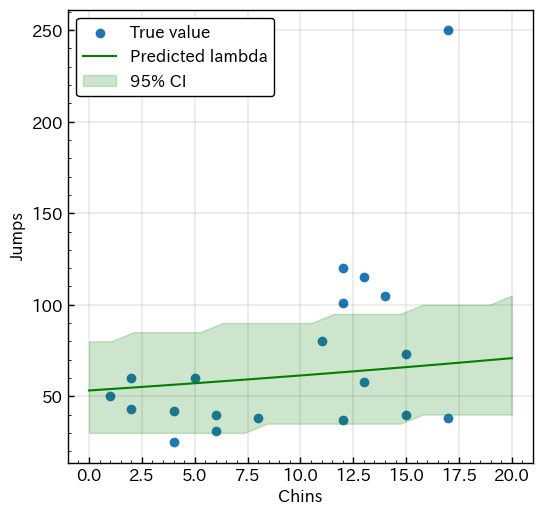

In [77]:
# 平均データを作る
cols = df.columns
# sampling parameter
ave_df_2 = pd.DataFrame({"Chins":np.linspace(0,20,20)})
for c in cols:
    if c!="Chins":
        ave_df_2[c] = df_2[c].mean()

# confidence range
lower = []
upper = []
for c in result_3.predict(ave_df_2):
    l, u = return_poissonupr_lwr(c, 0.05, 0.95)
    lower.append(l*5)
    upper.append(u*5)

plt.figure(figsize=(6,6))
plt.scatter(df["Chins"], df["Jumps"], label="True value")
plt.plot(ave_df_2["Chins"], result_3.predict(ave_df_2)*5, label="Predicted lambda", color="green")
plt.fill_between(ave_df_2["Chins"], lower, upper, label="95% CI", color="green", alpha=0.2)
plt.xlabel("Chins")
plt.ylabel("Jumps")
plt.legend()

信頼区間はガタガタとした表記となったが、サンプル範囲は先ほどよりもカバーできている。<br>
例えばChins (0, 5)の区間で、データの分布と比較すると、

In [91]:
def return_poisson_dist(lambda_:float):

    range_ = np.linspace(0.01, 0.99, 100)
    # poisson ppf
    poi = poisson(lambda_)
    ppf = []
    for r in range_:
        ppf.append(poi.ppf(r))

    return ppf

<Axes: xlabel='Jumps', ylabel='Density'>

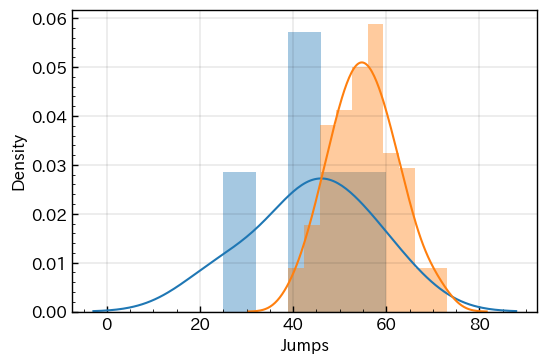

In [96]:
# 実データの区間データ
df_ = df[(df["Chins"]>0)&(df["Chins"]<5)]
# 予測サンプリング
# 平均値
ave_df_2_ = ave_df_2.copy()
ave_df_2_["Pred"] = result_3.predict(ave_df_2)*5
mu = ave_df_2_[(ave_df_2_["Chins"]>0)&(ave_df_2_["Chins"]<5)]["Pred"].mean()
poisson_samp = return_poisson_dist(lambda_=mu)

sns.distplot(df_["Jumps"], bins=5)
sns.distplot(poisson_samp, bins=10)

モデルの分布と実際の分布の一致性が取れてない部分は、その他の説明変数の影響があり。